# Beer Inventory Optimization

You manage a chain of convenience stores that retail cases of beer. You are seeking to optimize the quantities your purchase for each store:  
- your supplier provides a delivery every morning before you open, but none throughout the day
- you can place an order for the following day once you know the current day's results
- ideally, you would stock only enough inventory for the day's demand:
    - every unit carries financing and opportunity costs, so you don't want to have too much
    - however, if demand exceeds your inventory for a given day, these sales (and profits) are lost
- you have the following information about the distribution of demand:
    - demand follows a Poisson distribution, with a distinct mean for every day of the week
    - demand is not entirely independent from one day to the next: warm sunny days, for example, increase expected demand - but are often followed by more high-demand warm and sunny days  

In the following Notebook, we will describe the problem in quantitative terms and compare the expected results of two types of solutions:  
1. a "closed-loop" solution, in which all purchase order decisions are made at the beginning of the week
2. an "open-loop" solution, in which purchase order decisions are made throughout the week, as more information becomes available

## Quantitative problem definition

### Notation

- Each day will be indexed by $t\in\{0,1,...,N\},\ N=6$, representing the days from Monday through Sunday
- $D_t$ is the daily demand for the day $t$
- $\mu_t$ is the unconditional expected demand for day $t$
- $I_{t^-}$ and $I_t$ is the inventory at the beginning of day $t$ before and after the delivery, respectively
- $S_t$ is the number of units sold on day $t$
- $G_t$ is the profit associated to day $t$
    - $g$ is the unit profit per sale
    - $c$ is the unit carrying cost

### Elementary relationships

- $S_t = \min(D_t, I_t) \rightarrow$ we can't sell more than we have or than people want to buy
- $I_{t^-} = I_{t-1} - S_{t-1} \rightarrow$ the starting inventory is yesterday's inventory, minus yesterday's sales
- $G_t = gS_t - cI_t = g\cdot\min(D_t, I_t)-c\cdot I_t\rightarrow$ the day's profits are the unit profit times sales, minus the unit carrying costs times starting inventory



### Framework

We now define the problem, loosely using the canonical framework proposed by Powell:$^{[1]}$



#### Decision variable

At the beginning of each day, you need to decide how many units to stock. We will note the optimal daily inventory $I_t^*$. There are two constraints to our action space:  
- we assume that inventory must be greater or equal to zero: retail beer buyers don't usually tolerate back-orders/lead times, so if you encounter demand you cannot fulfill on the spot, those sales are lost;  
- we assume that your supplier will not take back unwanted stock, so the day's inventory cannot be lower than whatever is left over from the previous day.  

Taking these constraints together, we note our *feasible* policy by $\tilde I_t^*$ and define it as:
$$\tilde I_t^* \equiv \big\{I_t^*:\ I_t^*\ge \max\{0, I_{t^-}\}\big\}$$  
where $I_{t^-}$ will denote the leftover inventory from the previous day.


#### State variables

At each decision point, we need two key pieces of information:  
- $D_{t-1}$, the previous day's realized demand - which modifies the probability distribution of the current day's demand
- $I_{t^-}$, the inventory at the beginning of day *before* deciding on the inventory to stock - which constrains our action space

A complication arises from the fact that these state components have no upper bound: we will need to provide one that is high enough to not skew our results, yet low enough to keep computational demands reasonable. We will define this upper bound later, but for now let us simply state that we will bound $D_{t}$ and $I_{t^-}$ by some integer $K_t$. Thus:  
- $D_{t-1} \in \big\{\{0,1,...,K_{t-1}\}\cup\{k:\ k­>K_{t-1}\}\big\}$
    - we will approximate the complement of $\{D_{t-1}\le K_{t-1}\}$
- $I_{t^-} \in \{0,1,...,K_t\}$

We will combine these components in a tuple we will call, reusing Powell's notation, $S_t\equiv(I_{t^-}, D_{t-1})$.  

We will also assume independence between weeks and an absence of starting inventory, so that $S_0=(0, c)$, with $c$ an arbitrary constant that is ignored.

#### Transition function

We must also define a transition function $f:(I_t, D_t)\mapsto (I_{(t+1)^-}, \mathbb{E}[D_{t+1}])$. Using our previous definitions, we have that $I_{{(t+1)}^-} = \max(0, I_t - D_t)$.

With regards to $D_t$, which is the only random element in our problem, our analysts believe daily demand follows a $Poisson(\lambda_t)$ distribution, where the $\lambda_t$ parameter depends on the day's unconditional mean and the ratio of observed-to-expected demand for the previous day. We believe the following model to be a good approximation of demand:
$$D_t|D_{t-1}\sim Poisson\Big(\lambda_t=\frac{\mu_t}{2}\big(1 + \frac{D_{t-1}}{\mu_{t-1}}\big)\Big)$$

Since a Poisson distribution's expectation is its $\lambda$ parameter, we have:
$$f(I_t, D_t) = \Big(\max(0, I_t - D_t), \ \frac{\mu_{t+1}}{2}\big(1 + \frac{D_{t}}{\mu_{t}}\big)\Big)$$


#### Objective function

Our goal is obviously to maximize expected profits. Mathematically, we can represent this objective as:
$$\underset{\tilde I_t^*,\ t=\{0,1,...,N\}}{\max} \mathbb{E}\Big[\sum_{t=0}^N G_t \Big]$$

### Assumptions

To simplify the problem, we make a few assumptions that we will need to drop in a more thorough analysis, should you decide to retain our services:  

1. We assume the availability of reliable demand data. In practice, your in-house "demand" data will only include sales, and unless you've never run out of inventory, lost sales will need to be estimated using statistical models and external data;
2. We assume that your supplier's deliveries are always on time and are subject to neither minimum/maximum quantities or volume-based discounts;
3. We assume you have unlimited storage space in your backstore, so there is no upper bound on inventory;
4. We assume independence between weeks, i.e. a given Sunday's demand has no influence on the following Monday's;
5. We assume that the only information available to predict the following day's demand is the previous day's demand. In practice we can build a more precise model using data about the weather, the cultural/sporting calendar, etc.  

Without further ado, let's dive in!

## Model

### Imports

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from typing import Union

### Constants

In [2]:
# Unconditional expectations
mu = np.array([3, 3.5, 4.5, 8, 20, 30, 16])
N = len(mu) - 1

# Profit and daily carrying cost per unit
g = 5.
c = 2.

### Demand model and simulations

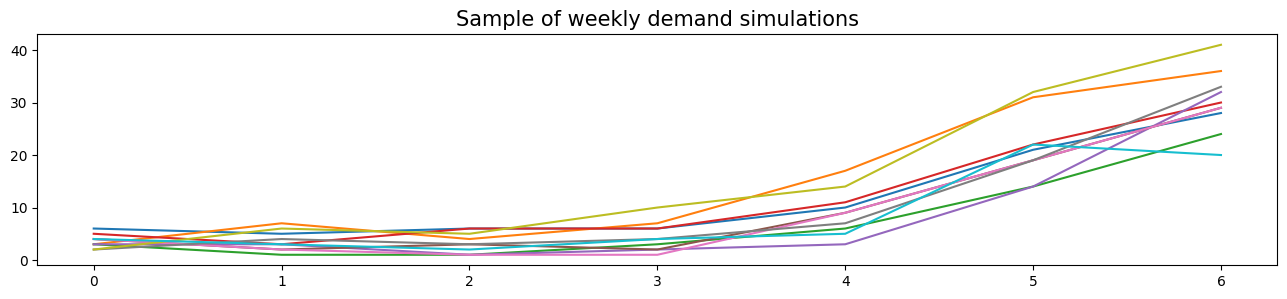

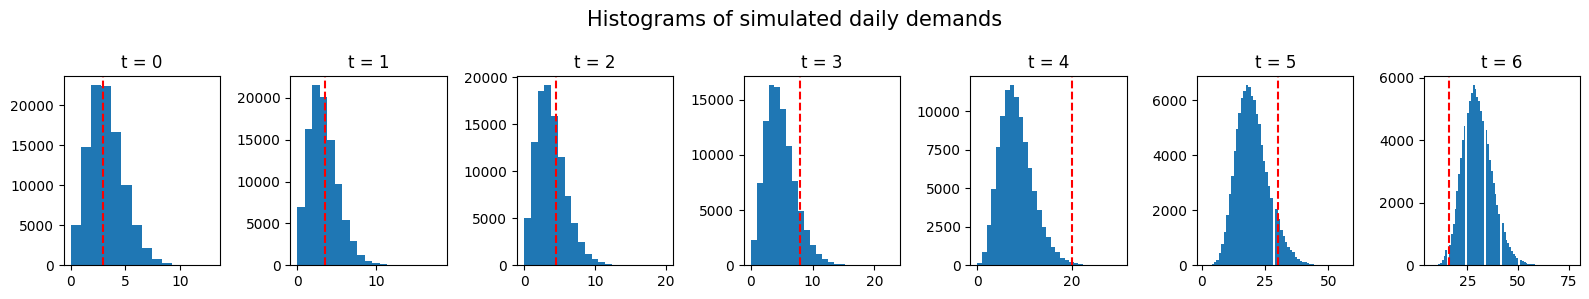

In [3]:
def conditional_distribution(ps_ratio: Union[float, np.ndarray],
                             mu_t: float,
                             *args, **kwargs):
    # Ratio(s) need to be a column vector
    ps_ratio = np.array([ps_ratio]).flatten()[:, np.newaxis]
    assert np.all(ps_ratio >= 0), "Cannot have negative demand!"
    assert mu_t > 0, "Inconditional mean must be strictly positive!"
    return 0.5 * mu_t * (1 + ps_ratio)


def simulate_daily(*args, **kwargs):
    """Given an unconditional mean and a vector of previous-day
    ratios, simulates the following day's demand (one simulation
    per previous-day ratio provided)"""
    lambda_vec = conditional_distribution(*args, **kwargs)
    return poisson.rvs(mu=lambda_vec).flatten()


def simulate_weekly(m: int,
                    unconditional: np.ndarray):
    """Simulates 'm' weeks of demand, handling all serial dependencies."""
    N = len(unconditional)
    results = np.zeros((m, N))
    previous = np.ones(m)
    _mu = unconditional[0]
    for t in range(N):
        results[:, t] = simulate_daily(previous, _mu)
        previous = results[:, t] / _mu
        _mu = unconditional[t]
    return results


toy_sim = simulate_weekly(10, mu)
plt.figure(figsize=(16,3))
plt.plot(toy_sim.T)
plt.title("Sample of weekly demand simulations", fontsize=15)
plt.show()

def plot_daily_sims(sims: np.ndarray,
                    unconditional: np.ndarray = None):
    axes = plt.subplots(ncols=sims.shape[1], figsize=(16,3))[1]
    for t, ax in enumerate(axes):
        x = large_sim[:, t]
        ax.hist(x, bins=int(x.max()+1))
        if unconditional is not None:
            ax.axvline(unconditional[t], color="red", linestyle="dashed")
        ax.set_title(f"t = {t}")
    plt.suptitle("Histograms of simulated daily demands", fontsize=15)
    plt.tight_layout()
    plt.show()

large_sim = simulate_weekly(100000, mu)
plot_daily_sims(large_sim, mu)

### Inventory optimization

First, we need some functions to compute:  
- conditional profits,
- their probability masses and
- our partial transition function for $I_{t^-}$

In [4]:
def case_profit(D_t: np.ndarray,
                I_t: Union[int, np.ndarray],
                unit_profit: float = g,
                unit_cost: float = c,
                *args, **kwargs):
    """Deterministically computes daily profit, given a demand
    vector ('D_t'), a starting inventory level ('I_t') and unit
    profit/cost levels."""
    return unit_profit * np.minimum(D_t, I_t) - unit_cost * I_t


def compute_transition_matrix(k: np.ndarray,
                              include_survival: bool = True,
                              *args, **kwargs):
    """Compute the conditional means and returns a vector of probability 
    masses for each member of the row vector defined by 'k'."""
    cond_mu_t = conditional_distribution(*args, **kwargs)
    pmf = poisson.pmf(k=k, mu=cond_mu_t)
    if include_survival:
        pmf = np.concatenate([pmf, 1 - pmf.sum(1)[:, np.newaxis]], axis=1)
    return pmf


def inventory_transition(ub: int):
    """Produces a matrix of ending inventory:
        - each row represents a realized demand level
        - each column represents a starting inventory level
        """
    D_t = np.arange(ub + 1)[:, np.newaxis]
    I_t = np.arange(ub)[np.newaxis]
    return np.maximum(0, I_t - D_t)

Things get a bit more complicated here: while optimizing for a single day is pretty trivial (just start with $I_t=0$ and increment until the expected daily profit starts going down), we have to consider that any leftover inventory from a previous day constrains the following day's action space, potentially making unfeasible choices that would otherwise be optimal. To handle this sort of scenario, we will apply the **back-chain algorithm** we saw in class.  

We established earlier that our daily profit $G_t$ for day $t$ was given by:
$$G_t = g\cdot\min(D_t, I_t)-c\cdot I_t$$
Let $\hat G_t$ be the expected sum of profit over days $\{t,t+1,...,N\}$. We have:
$$\begin{aligned}
\hat G_t 
&\equiv \mathbb{E}\Big[\sum_{s=t}^N G_s \Big] \\

\Rightarrow \hat G_t\big|D_t,I_t
& = G_t(D_t, I_t) + \mathbb{E}\Big[\sum_{s=t+1}^N G_s \big| D_t, I_t \Big]\\
& = G_t(D_t, I_t) + \mathbb{E}\Big[\sum_{s=t+1}^N G_s \big| \big\{D_t\big\}\cap \big\{I_{t+1}\ge\max(0,I_t-D_t)\big\} \Big]
\end{aligned}
$$

### Back-chain algorithm

The following description of the back-chain algorithm is directly adapted from course slides $^{[2]}$, with tweaks to fit the notation to our own case. We will also skip its very first step, which is trivial to our case (it would concern the end of day 6 - in what follows, $\hat G_{N+1}=0$ in all cases).

For every $t\in\{N, N-1, ..., 0\}$:  

$\quad$ For every $s\in S_t$:  
$\quad\quad\hat G_t(s)\leftarrow \underset{i_t:\ i_t\ge\max\{0,\ I_{t^-}\}}{\max}\Bigg\{
    \mathbb{E}\Big[G_t|s, i_t\Big] 
    + \hat G_{t+1}\big(f(s, i_t, D_t)\big)
\Bigg\}$  
$\quad\quad \tilde I_t^*(s)\leftarrow 
\underset{i_t:\ i_t\ge\max\{0,\ I_{t^-}\}}{\argmax}\Bigg\{
    \mathbb{E}\Big[G_t|s, i_t\Big] 
    + \hat G_{t+1}\big(f(s, i_t, D_t)\big)
\Bigg\}$

#### With regards to the upper bound

As mentioned earlier, our state space $S_t=(I_{t^-}, D_{t-1})$ takes values on $\mathbb{N}^2$, with no upper bound. We will therefore impose an arbitrary upper bound $K_t$, to let us use the back-chain algorithm directly.  

For this bound, we will take the vector of simulated maxima, $\boldsymbol{d}^{max}=(d^{max}_0, d^{max}_1, ..., d^{max}_N)$ where $d^{max}_t\equiv\max D_t^{sim}$, and for each $t$ use $k_t=\underset{i\in[t-1,\ t+1]}{\max}\{d^{max}_i\}$. This will produce an excess of cases to consider when low-demand days neighbour high-demand ones, but will help us ensure the cases we care about can be computed properly.

#### Step-wise implementation

1. Compute the current step's conditional gain matrix, $G_t$.
2. If the $\hat G_{t+1}$ matrix (next-step conditional gains) is provided (when $t<N-1$), for each $j=I_t\in\{0,1,...,k_t\}$:  
    - mask the unfeasible next-step states (where $I_{(t+1)^-} < I_t - D_t$)
    - set (remember that $D_t$ here is a column vector): 
        - $\tilde I_{t+1}^*(f(s,j,D_t))\leftarrow \underset{i_{t+1}:\ i_{(t+1)^-}\ \ge\ j - D_t}{\argmax}\big\{\hat G_{t+1}\big(f(s, i_{t+1}, D_t)\big)\big\}$
        - $\hat G_{t+1}^*(f(s,j,D_t))\leftarrow \underset{i_{t+1}:\ i_{(t+1)^-}\ \ge\ j - D_t}{\max}\big\{\hat G_{t+1}\big(f(s, i_{t+1}, D_t)\big)\big\}$
3. Set $\hat G_t|D_t,I_t\leftarrow G_t + \hat G_{t+1}^*$
4. Append a row to the bottom of $\hat G_t|D_t,I_t$ (in our case, we simply clone $(\hat G_t|D_t,I_t)_{K_t,\cdot}$) to stand in for cases where $D_t>k_t$  

Since $\hat G_t|(D_t,I_t)$ is still conditional, we need to compute a transition-probabilities matrix to weigh each $D_t$ scenario:  

5. Compute the $P\in[0,1]^{(k_t+1)\times(k_t+2)}$ transition matrix, where:
$$P_{\cdot j}\equiv\Bigg\{
\begin{array}{ccc}
    \mathbb{P}(D_t=j|D_{t-1}) &,& \text{if}\ j\le k_t \\
    \mathbb{P}(D_t>k_t|D_{t-1}) &,& \text{otherwise}\\
\end{array}
$$ 

7. Finally (for the open-loop case), we get:  
- $\hat G_t\leftarrow P\cdot(\hat G_t|D_t,I_t)$
- $\tilde I_t^*$ is simply, for each $D_{t-1}$, the index of the row-wise maximum of $\hat G_t$

8. In the **closed-loop** case, we need to multiply $\hat G_t$ by $\hat p_{t-1}^{sim}$, the vector of simulated masses of previous-day, to get $\hat G_t$ into a vector form that depends only on the action taken on day $t$, since we need to fix a single policy, no matter what happened the day before. $\tilde I_t^*$ is then taken as the index of $\hat G_t$'s maximum.

In [5]:
def mask_func(arr, k):
    """Produces a masking matrix, with values of 1 where
        the sum of row and column indices is smaller than
        a specified 'k' value.
        """
    n, d = arr.shape
    return np.array([
        [i + j < k for j in range(d)]
        for i in range(n)
    ]) * 1


def open_loop_optima(ns_G_hat: np.ndarray,
                     D_t: np.ndarray,
                     I_t: np.ndarray,
                     verbose: bool = False,
                     *args, **kwargs):
    ns_Kt = ns_G_hat.shape[1]
    # Progressively filter feasible set, then take the row-wise optima
    #ns_policy = np.zeros((D_t.shape[0], len(I_t)))
    ns_policy = np.zeros_like(ns_G_hat)
    floor = np.absolute(ns_G_hat).max()
    J = range(ns_Kt)
    for j in J:
        mask = np.nan_to_num(mask_func(ns_G_hat, j) * floor)
        ns_policy[:,j] = np.argmax(ns_G_hat - mask, axis=1)
    # Build the corresponding set of matrix indices
    cs_Kt = ns_G_hat.shape[0]
    row_sel = np.repeat(range(cs_Kt), ns_Kt).reshape(cs_Kt, ns_Kt)
    col_sel = ns_policy.astype(int)
    ns_optima = np.squeeze(ns_G_hat[row_sel, col_sel])
    if verbose:
        r = lambda arr: np.round(arr, 2)
        print(f"\nNext-step E[profits] matrix: {ns_G_hat.shape}\n{r(ns_G_hat)}")
        print(f"\nNext-step policy, by case: {ns_policy.shape}\n{ns_policy}")
        print(f"\nNext-step optima, by case: {ns_optima.shape}\n{r(ns_optima)}")
    return ns_optima


def closed_loop_optima(ns_G_hat: pd.Series,
                       ub: int,
                       verbose: bool = False,
                       *args, **kwargs):
    # Determine associated next-step optima
    ns_pol = ns_G_hat.idxmax()
    ns_inv = inventory_transition(ub=ub)
    feasible = ~np.any(ns_inv > ns_pol, axis=0)
    ns_Gt = np.array([
        ns_G_hat.loc[It_row]
        for It_row in ns_inv[:, feasible]
    ])
    if verbose:
        r = lambda arr: np.round(arr, 2)
        print(f"\nNext-step Gt distribution: {ns_G_hat.shape}\n{ns_G_hat}")
        print(f"\nNext-step policy: {ns_pol}")
        print(f"\nNext-step Gt: {ns_Gt.shape}\n{r(ns_Gt)}")
    return ns_Gt


def back_chain_step(cs_K_t: int,
                    ps_K_t: int,
                    mu_t: float,
                    ps_mu_t: float = None,
                    ns_G_hat: Union[pd.Series, np.ndarray] = None,
                    open_loop: bool = True,
                    verbose: bool = False,
                    sim_Dt: np.ndarray = None,
                    *args, **kwargs):
    # Compute this step's conditional-gains matrix
    D_t = np.arange(int(ps_K_t) + 1)[:, np.newaxis]
    I_t = np.arange(int(cs_K_t) + 1)
    G_t = case_profit(D_t, I_t, *args, **kwargs)
    if verbose: 
        r = lambda arr: np.round(arr, 2)
        print(f"\nCurrent-step case profits: {G_t.shape}\n{r(G_t)}")
        
    # Compute the transition probability matrix
    ratios = np.ones_like(D_t) if ps_mu_t is None else D_t / ps_mu_t
    tm = compute_transition_matrix(
        k = D_t.T,
        ps_ratio = ratios,
        mu_t = mu_t
    )
    assert np.allclose(tm.sum(1), 1), \
        f"Probabilities not summing to 1!\n{r(tm.sum(1))}\n{r(tm)}"
    
    # Include the following round's optima, if applicable
    if ns_G_hat is not None:
        pol_func = open_loop_optima if open_loop else closed_loop_optima
        ns_optima = pol_func(
            ns_G_hat = ns_G_hat, 
            D_t = D_t,
            I_t = I_t,
            ub = cs_K_t,
            verbose = verbose
        )
        # More often than not, the matrix dimensions will not match
        # Therefore, we need to truncate the larger dimensions; we assume
        # any impact on results will be negligible since the truncated
        # positions represent cases that are extremely unlikely
        n, d = G_t.shape
        m, k = ns_optima.shape
        G_t[:m, :k] += ns_optima[:n, :d]
    # We will assume that if {D_t > K}, the expected next-step gain
    # is the same as for {D_t = K}
    G_t = np.concatenate([G_t, G_t[[-1]]])
    # Compute expected gains for starting states
    G_hat = tm.dot(G_t)
    # Compute policy
    if open_loop:
        policy = {i: best for i, best in enumerate(np.argmax(G_hat, axis=1))}
    else:
        if sim_Dt is None:
            print("WARNING! No simulations provided, policy may not be optimal!")
            weights = np.ones_like(D_t) / D_t.shape[0]
        else:
            weights = np.array([np.mean(sim_Dt == d) for d in D_t])
        G_hat = pd.Series(weights.dot(G_hat), index=I_t.astype(int))
        policy = G_hat.idxmax()

    if verbose:
        print(f"\nConditional G-hat: {G_t.shape}\n{r(G_t)}")
        print(f"\nTransition probabilities: {tm.shape}\n{r(tm)}")
        print(f"\nG-hat: {G_hat.shape}\n{r(G_hat)}")
        if open_loop:
            pol_summary = (
                pd.DataFrame(
                    policy.values(), 
                    index=policy.keys(),
                    columns=["I*"])
                .groupby("I*")
                .apply(lambda x: f"[{x.index.min()}-{x.index.max()}]")
                .rename(index="ps_D_t")
                )
            pol_summary.index.name = "I*"
            print(f"\nPolicy, grouped by previous-step demand:\n{pol_summary}")
        else:
            print(f"\nPolicy, this step: {policy}")
    return G_hat, policy

#### Recursion

Once the step-wise process is built, creating an optimal policy for the entire problem is a simple matter of starting from the end and working each step recursively until we reach $t=0$.

In [6]:
def back_chain_optimization(unconditional_means: np.ndarray,
                            max_values: np.ndarray,
                            simulations: np.ndarray = None,
                            verbose: bool = False,
                            *args, **kwargs):
    n = len(unconditional_means) - 1
    expectations, policy = {}, {}
    for t in range(n, -1, -1):
        # Decide on upper bounds to apply
        cs_Kt = max(max_values[t:(t+2)])
        ps_Kt = 1 if t == 0 else max(max_values[(t-1):(t+1)])
        if t > 0:
            cs_Kt = max(cs_Kt, ps_Kt)
        if verbose:
            print(f"\nStep {t}\n  C/S K: {cs_Kt}\n  P/S K: {ps_Kt}")
        expectations[t], policy[t] = back_chain_step(
            cs_K_t = cs_Kt,
            ps_K_t = ps_Kt,
            mu_t = unconditional_means[t],
            ps_mu_t = (None if t == 0 else unconditional_means[t-1]),
            ns_G_hat = (None if t == n else expectations[t+1]),
            sim_Dt = (None if simulations is None else simulations[:, t]),
            verbose = verbose,
            *args, **kwargs
        )
    # Formatting
    if isinstance(policy[0], dict):
        policy = {
            step: pd.DataFrame(
                pol.values(), 
                index=pol.keys()
            ) for step, pol in policy.items()
        }
    else:
        policy = pd.Series(
            policy.values(), 
            index = policy.keys()
        ).sort_index()
    return expectations, policy

sim = large_sim
ol_gains, ol_policy = back_chain_optimization(
    unconditional_means = mu,
    max_values = sim.max(0)
)

cl_gains, cl_policy = back_chain_optimization(
    unconditional_means = mu,
    max_values = sim.max(0),
    open_loop = False,
    simulations = sim
)

#### Visualization

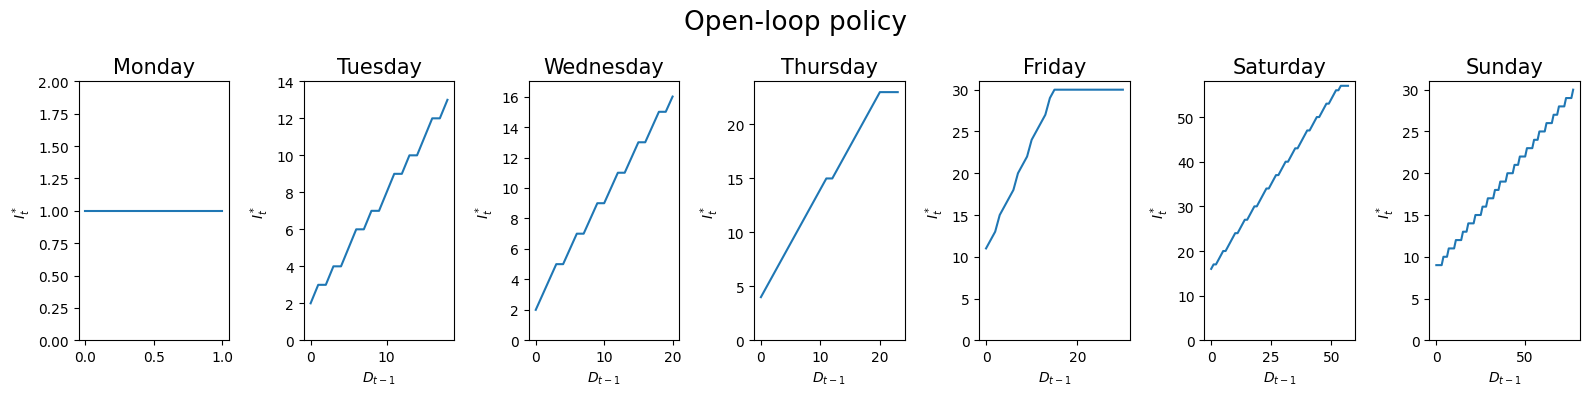

Closed-loop policy:
Monday        4
Tuesday       8
Wednesday    12
Thursday     27
Friday       31
Saturday     31
Sunday       17
dtype: int64


In [7]:
days = [
    "Monday", "Tuesday", "Wednesday", "Thursday", 
    "Friday", "Saturday", "Sunday"]

def plot_ol_policy(policy_dfs: dict):
    n = len(policy_dfs)
    axes = plt.subplots(ncols=n, figsize=(16, 4))[1]
    for t in range(n):
        axes[t].plot(policy_dfs[t])
        axes[t].set_title(days[t], fontsize=15)
        axes[t].set_ylim([0, int(policy_dfs[t].max()) + 1])
        axes[t].set_ylabel(f"$I_t^*$")
        if t > 0:
            axes[t].set_xlabel(r"$D_{t-1}$")
    plt.suptitle("Open-loop policy", fontsize=19)
    plt.tight_layout()
    plt.show()

plot_ol_policy(ol_policy)

# The closed-loop policy is simple enough to output textually
cl_policy.index = days
print(f"Closed-loop policy:\n{cl_policy}")
cl_policy.index = range(N + 1) # Change it back otherwise things break!

## Contrasting approaches: closed- vs. open-loop

Ideally, you would like a *closed-loop* solution, in which we set a policy at the beginning of the week and then stick to, saving you complexity and computing time (perhaps this is also easier to deal with for your supplier). However, we will show that an *open-loop* solution, in which each decision is made at the last possible moment, when relevant information is maximized, will do a better job of maximizing your profits.$^{[3]}$  

We will start by creating a function that loops through each step $t\in{0,1,...,N}$ for a set of simulations, executing a specified policy and recording the gains. We will call this function `forward_propagation`, borrowing a popular machine-learning term that fits well with what we are doing here.  

In [8]:
def forward_propagation_step(ps_Dt: np.ndarray,
                             cs_Dt: np.ndarray,
                             cs_It_start: np.ndarray,
                             policy: callable,
                             step: int = 0,
                             *args, **kwargs):
    # Apply the constrained policy
    It_star = np.maximum(
        cs_It_start, 
        policy(step, ps_Dt),
        *args, **kwargs
    )
    # Compute this round's gains
    cs_Gt = case_profit(D_t=cs_Dt, I_t=It_star, *args, **kwargs)
    # Compute the next step's starting inventory
    ns_It_start = np.maximum(0, It_star - cs_Dt)
    return (
        cs_Gt.flatten(),
        ns_It_start
    )


def forward_propagation(policy: callable,
                        demand_matrix: np.ndarray,
                        verbose: bool = False,
                        *args, **kwargs):
    if verbose:
        print(f"Policy function: {policy}")
    m, n = demand_matrix.shape
    Gt = np.zeros((m, n))
    It_start = np.zeros(m)
    for t in range(n):
        Gt[:, t], It_start = forward_propagation_step(
            ps_Dt = (np.zeros(m) if t == 0 else demand_matrix[:, t-1]),
            cs_Dt = demand_matrix[:, t],
            cs_It_start = It_start,
            policy = policy,
            step = t,
            *args, **kwargs
        )
    return Gt

### Policy closures

The policies we created so far are nothing more than Pandas objects. To actually *use* them, we need functionality that translates the information inside our policies into conditional *decisions*.

In [9]:
def open_loop_policy(stepwise_policies: dict,
                     *args, **kwargs):
    def func(step: int,
             ps_Dt: np.ndarray,
             *args, **kwargs):
        policy = stepwise_policies[step]
        ps_Dt = np.minimum(ps_Dt, policy.index.max())
        next_steps = policy.loc[ps_Dt].to_numpy().flatten()
        return next_steps
    return func


def closed_loop_policy(stepwise_policies: pd.Series, 
                       *args, **kwargs):
    def func(step, *args, **kwargs):
        return stepwise_policies.loc[step]
    return func

### Comparison

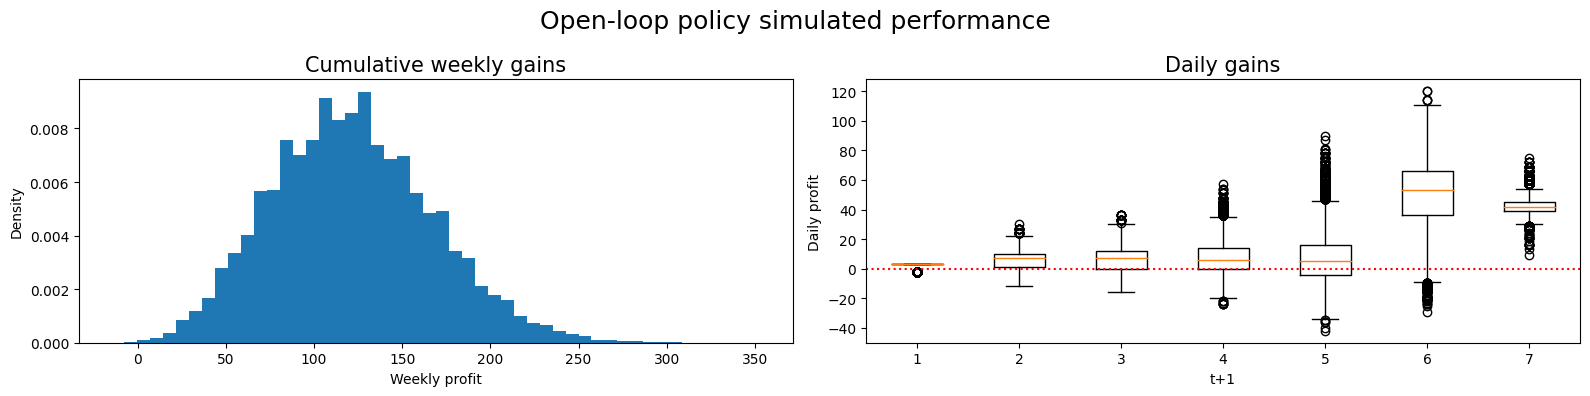

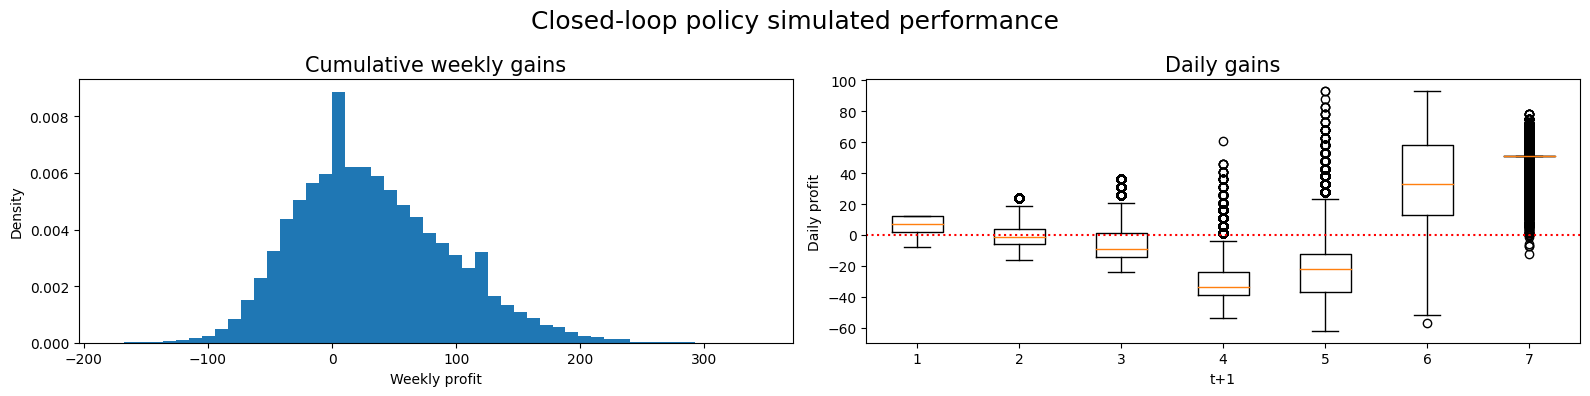

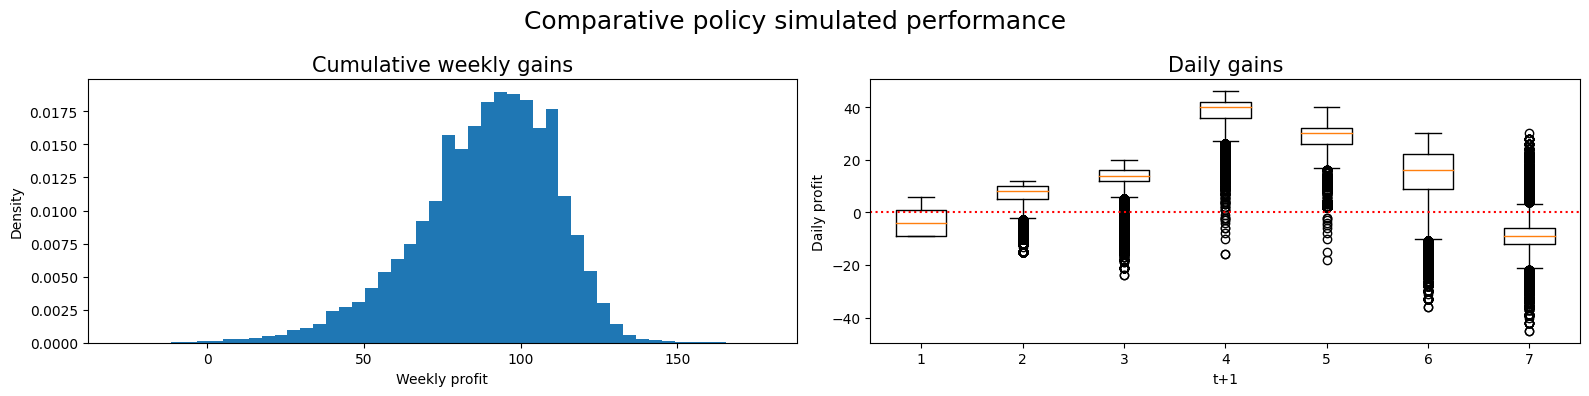

In [10]:
def plot_policy_performance(gains: np.ndarray,
                            label: str = "Chosen",
                            description: str = "{} policy simulated performance",
                            titles: list = [
                                "Cumulative weekly gains", 
                                "Daily gains"],
                            x_axes: list = ["Weekly profit", "t+1"],
                            y_axes: list = ["Density", "Daily profit"],
                            *args, **kwargs):
    axes = plt.subplots(ncols=2, figsize=(16,4))[1]
    axes[0].hist(gains.sum(1), bins=50, density=True)
    axes[1].boxplot(gains)
    axes[1].axhline(0, color="red", linestyle="dotted")
    for i in [0, 1]:
        axes[i].set_title(titles[i], fontsize=15)
        axes[i].set_xlabel(x_axes[i])
        axes[i].set_ylabel(y_axes[i])
    plt.suptitle(description.format(label), fontsize=18)
    plt.tight_layout()
    plt.show()

new_sim = simulate_weekly(100000, mu)

gains_open_loop = forward_propagation(
    policy = open_loop_policy(ol_policy),
    demand_matrix = new_sim
)
plot_policy_performance(
    gains = gains_open_loop,
    label = "Open-loop"
)

gains_closed_loop = forward_propagation(
    policy = closed_loop_policy(cl_policy),
    demand_matrix = new_sim
)
plot_policy_performance(
    gains = gains_closed_loop,
    label = "Closed-loop"
)

improvement = gains_open_loop - gains_closed_loop
plot_policy_performance(
    gains = improvement,
    label = "Comparative"
)

### Summary results

In [11]:
gains_cases = {"closed": gains_closed_loop, "open": gains_open_loop}

print("\nShare of loss-making weeks:")
for label, gains in gains_cases.items():
    print(f"\tWith {label}-loop solution: {np.mean(gains.sum(1) < 0) * 100:.2f}%")
    
print(f"\nMean weekly profits:")
for label, gains in gains_cases.items():
    print(f"\tWith {label}-loop solution:\t${gains.sum(1).mean():.2f}")
print(f"\t=> Improvement:\t{improvement.sum(1).mean():.2f}$ per week")


Share of loss-making weeks:
	With closed-loop solution: 31.34%
	With open-loop solution: 0.01%

Mean weekly profits:
	With closed-loop solution:	$32.93
	With open-loop solution:	$121.60
	=> Improvement:	88.67$ per week


This is what we call the *stochastic value of information*, i.e. the benefit from delaying decisions until the latest possible moment. Now this is one SKU, for one store, with a relatively rudimentary model... imagine what we could do by applying state-of-the-art purchasing algorithms for your entire chain!

## Sources

[1] Powell, W.B. (2017). A unified framework for stochastic optimization. *European Journal of Operation Research*. 275, 805-807.  
[2] Emma Frejinger. (9 Janvier 2023). *IFT 6521 Programmation dynamique Introduction* [notes de cours]. Département d’informatique et de recherche opérationnelle, Université de Montréal. StudiUM. https://stadium.umontreal.ca/  
[3] Idem